Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Ayush Koirala"
ID = "st122802"

---

# Lab 12: Gaussian Mixture Models (GMMs)

In lecture, we learned that the Gaussian Mixture Model (GMM) is a more sophisticated unsupervised clustering method than
$k$-means.

The GMM models a dataset $(\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(m)})$ as an i.i.d. sample from the following
generative model for each sample
$\mathbf{x}^{(i)}$:

1. Sample $z^{(i)}$ from a multinomial distribution over clusters $1..k$ according to probabilities $(\phi_1,\ldots,\phi_k)$.
2. Sample $\mathbf{x}^{(i)}$ from ${\cal N}(\mathbf{\mu}_{z^{(i)}},\Sigma_{z^{(i)}})$.

The parameters are estimated using the Expectation Maximization (EM) algorithm, which begins with a guess for parameters
$\phi_1,\ldots,\phi_k,\mu_1,\ldots,\mu_k,\Sigma_1,\ldots,\Sigma_k$ then iteratively alternates between computing a soft assignment
of data to clusters then updating the parameters according to that soft assignment.

First, we'll build a GMM model for a dataset then use the model for anomaly detection.

## Example 1: Anomaly detection

Let's generate synthetic data from a mixture of Gaussians, use EM to recover as best possible the ground truth parameters, and
then use the model to find "anomalies" (unusually unlikely points according to the model). First, we set up the ground truth
parameters and generate a dataset from those ground truth parameters:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Ground truth means and covariances for the data we'll generate

means_gt = [ [1,10], [10,1], [10,10] ]
sigmas_gt = [ np.matrix([[1, 0],[0, 1]]), np.matrix([[4,0],[0,1]]),
              np.matrix([[1,0],[0,4]]) ]

# Ground truth Prior probability (phi_j) for each cluster

phi_gt = [ 0.2, 0.2, 0.6 ]

# For more interesting covariances, you can also try, for example,
# [[11.31371, -0.70711],[11.31371, 0.70711]] or
# [[11.31371, 0.70711],[-11.31371, 0.70711]].

# Size of dataset

m = 500

# number of variables

n = len(means_gt[0])

# k number of clusters/outcomes

k = len(phi_gt)

# Ground truth indices of cluster identities

Z = [0]*m

# Generate a new k-means dataset

def gen_dataset():
    X = np.zeros((m,n))
    # Generate m samples from multinomial distribution using phi_gt
    z_vectors = np.random.multinomial(1, phi_gt, size=m)  # Result: binary matrix of size (m x k)
    for i in range(m):
        # Convert one-hot representation z_vectors[i,:] to an index
        Z[i] = np.where(z_vectors[i,:] == 1)[0][0]
        # Grab ground truth mean mu_{z^i}
        mu = means_gt[Z[i]]                
        # Grab ground truth covariance Sigma_{z^i}
        sigma = sigmas_gt[Z[i]]
        # Sample a 2D point from mu, sigma
        X[i,:] = np.random.multivariate_normal(mu,sigma,1)
    return X


X = gen_dataset()

Next, the EM algorithm itself. We have an initialization step and an iterative step.

In [3]:
def gen_dataset():
    X = np.zeros((m,n))
    # Generate m samples from multinomial distribution using phi_gt
    z_vectors = np.random.multinomial(1, phi_gt, size=m)  # Result: binary matrix of size (m x k)
    for i in range(m):
        # Convert one-hot representation z_vectors[i,:] to an index
        Z[i] = np.where(z_vectors[i,:] == 1)[0][0]
        # Grab ground truth mean mu_{z^i}
        mu = means_gt[Z[i]]                
        # Grab ground truth covariance Sigma_{z^i}
        sigma = sigmas_gt[Z[i]]
        # Sample a 2D point from mu, sigma
        X[i,:] = np.random.multivariate_normal(mu,sigma,1)
    return X
X = gen_dataset()
print(X.shape)

(500, 2)


In [4]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p

def gaussian(x, mean,covariance):
    k = len(mean)
    X = (x - mean).reshape(-1,1)
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * (X.T @ np.linalg.pinv(covariance) @ X))
    return p


# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j])
        pj_arr[:,j] = pj
        W[:,j] = Phi[j] * pj
    
    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(2,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    pj = np.max(pj_arr,axis=1)
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label

Let's run the model to convergence:

In [5]:
threshold = np.matrix(.01)

Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [6]:
print(Sigma)

[[[ 0.94734663  0.1610572 ]
  [ 0.1610572   4.3063373 ]]

 [[ 0.98392827 -0.01289035]
  [-0.01289035  1.13828645]]

 [[ 3.42426399  0.11226609]
  [ 0.11226609  0.86383644]]]


In [7]:
print(Phi)
print(phi_gt)

phi_gt = np.array(phi_gt).reshape(-1,1)
phi_mse = np.mean(np.min((Phi-phi_gt)**2,axis=1))

print(phi_mse)

[0.61543602 0.21       0.17456398]
[0.2, 0.2, 0.6]
0.00014609023576051173


In [8]:
print(Mu)
print(np.array(means_gt).T)

[[10.02332686  0.91963673 10.22408222]
 [ 9.95805598 10.0459402   1.06872033]]
[[ 1 10 10]
 [10  1 10]]


In [9]:
print(Sigma)
print(sigmas_gt)

[[[ 0.94734663  0.1610572 ]
  [ 0.1610572   4.3063373 ]]

 [[ 0.98392827 -0.01289035]
  [-0.01289035  1.13828645]]

 [[ 3.42426399  0.11226609]
  [ 0.11226609  0.86383644]]]
[matrix([[1, 0],
        [0, 1]]), matrix([[4, 0],
        [0, 1]]), matrix([[1, 0],
        [0, 4]])]


### In-class exercise

Determine how close the estimated parmeters Phi, Mu, and Sigma are to the ground trouth values set up at the beginning
of the experiment. Report your results and briefly discuss in your lab report.

Next, we continue to find outliers:

In [10]:
outlier_prob = .01
outliers = np.nonzero(pj < outlier_prob)[0]

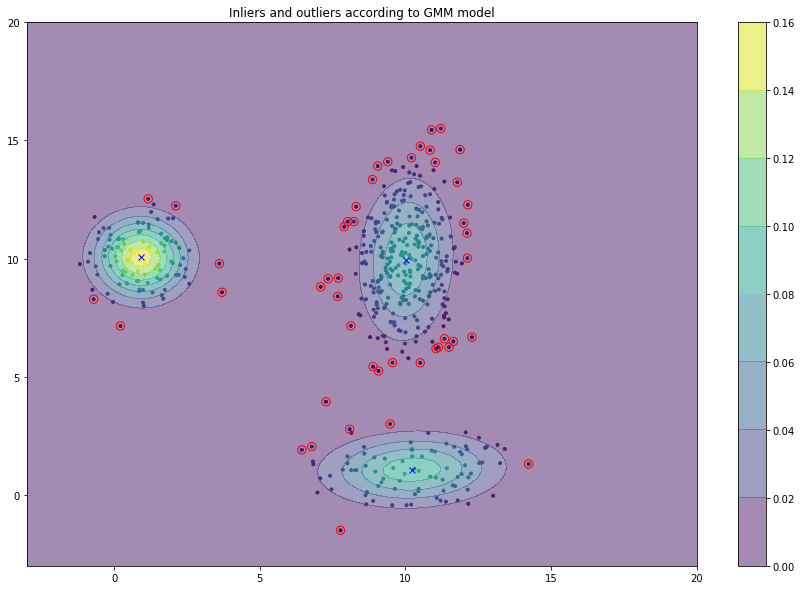

In [11]:
fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
cbar = fig1.colorbar(cp)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()

### In-class exercise

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a
tight cluster. First, understand why, and explain in your report.  Second, read about Mahalanobis distance
of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance
to get a better notion of outliers in this dataset.

### Exercise 1.1 (10 points)

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a tight cluster. Understand why, and explain in your report. 

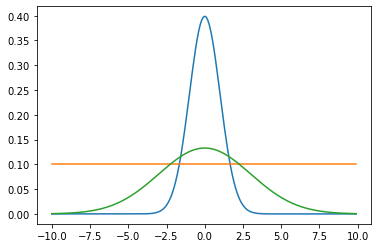

In [12]:
# You may need code to explain
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot between -10 and 10 with .1 steps.
x_axis = np.arange(-10, 10, 0.1)

thresh = np.full((200,), 0.1)
plt.plot(x_axis, norm.pdf(x_axis,0,1)) #mean 0, std 1
plt.plot(x_axis, thresh)
plt.plot(x_axis, norm.pdf(x_axis,0,3)) #mean 0, std 3
plt.show()

YOUR ANSWER HERE

Broader cluster means larger standard deviation, meaning wider probability density function. Since the 
area under any probability density function is equal to 1, wider pdf or larger standard deviation will make 
the function to be taller at the mean. In summary, larger standard deviation will have broader bell shape 
while smaller standard deviation will have narrower bell shape.
When we set the same hard cut-off for both narrower and wider bell shaped pdf, then we will be cutting off 
more points for wider bell shape pdf cluster or simply Broader cluster than that of narrower cluster because
the area outside that cut-off is greater for broader cluster than the narrower cluster.

### Exercise 1.2 (15 points)

Read about Mahalanobis distance of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance to get a better notion of outliers in this dataset.
1. Explain what is Mahalanobis (5 points)
2. Write code Mahalanobis (10 points)

#### Explain what is Mahalanobis (5 points)

YOUR ANSWER HERE

Mahalanobis distance is a measure of the distance between a point P and a distribution D, introduced by P.C. Mahalanobis. It is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D. The distance is zero for P at the mean of D and grows as P moves away from the mean along each principal component axis. If each of these axes is rescaled to have unit variance, then the Mahalanobis distance corresponds to standard Euclidean Distance in the transformed space.

The Mahalanobis distance of an observation:

$$ D_M(\boldsymbol{x}) = \sqrt{(\boldsymbol{x} - \boldsymbol{\mu})^T \boldsymbol{S}^{-1} (\boldsymbol{x} - \boldsymbol{\mu})} $$

where $\boldsymbol{x}$ is a vector from a set of observations with mean $\boldsymbol{\mu} $ and covariance matrix $\boldsymbol{S}$

[Source: https://en.wikipedia.org/wiki/Mahalanobis_distance] 

In [13]:
print(len(Sigma))

3


#### Write code Mahalanobis (10 points)

In [14]:
print(Sigma.shape)
print(Mu.shape)
print(X.shape)

m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        # get all row data from target column
        mu = Mu[:,kk]
        # get target sigma
        sig = Sigma[kk]
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(-1, 1)
        # calculate distance from diff and sigma
        distance = np.sqrt(diff.T @ sig_inv @ diff)
        # YOUR CODE HERE
        # raise NotImplementedError()
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = np.unique(np.argmin(m_distance, axis=1)), len(np.unique(np.argmin(m_distance, axis=1)))

max_z_score = 2.05
# find minimum distance
# hint: use np.min
min_distance = np.min(m_distance, axis=1)

# find outlier from min_distance
outlier = np.where(min_distance > max_z_score)


(3, 2, 2)
(2, 3)
(500, 2)


outlier (array([  9,  10,  25,  27,  41,  53,  56,  70,  74,  78,  81,  82,  94,
       116, 150, 151, 160, 165, 169, 178, 193, 224, 227, 240, 244, 248,
       253, 255, 267, 288, 299, 301, 306, 338, 340, 349, 368, 374, 375,
       379, 398, 414, 418, 428, 450, 451, 459, 468, 475, 478, 485, 494]),)


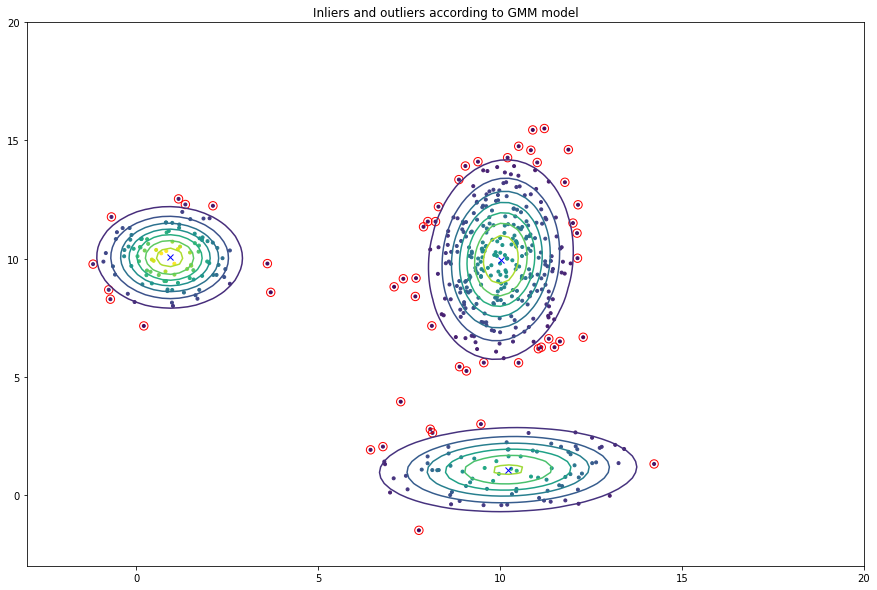

success!


In [15]:
# Test function: Do not remove
print('outlier', outlier)

fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX,YY,Z)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()
print('success!')
# End test function

## Example 2: Customer segmentation

In this example we will use the Kaggle customer segmentation
from last week dataset [Mall_Customers.csv](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python).

Let's stick to just two dimensions in the dataset:

In [16]:
data = pd.read_csv('Mall_Customers.csv')
data = data.drop(['CustomerID', 'Gender', 'Age'], axis = 1)
print(data.head())

   Annual Income (k$)  Spending Score (1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40


In [17]:
X  = np.array(data, dtype=float)

n = X.shape[1]
m = X.shape[0]
k = 3

threshold = np.matrix(.01)

# Slightly different version of init_gmm due to the data format and spread
def init_gmm(X, k):
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        Phi[j] = 1/k
        Mu[:,j] = X[order[j],:].T
        Sigma[j,:,:] = np.cov(X.T)
    return Phi, Mu, Sigma


Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [18]:
print(Mu)

[[57.28749398 95.58281619 51.22191253]
 [54.89123078 27.73418382 53.12655528]]


In [19]:
print(Sigma)

[[[ 537.16926579  531.58450758]
  [ 531.58450758  667.83925176]]

 [[ 410.16125315  290.11952411]
  [ 290.11952411  653.23709307]]

 [[ 404.53604297 -378.40805387]
  [-378.40805387  437.40911995]]]


The first row represents annual income, whereas the second row represents the spending score. From what i noticed, these values changes in every iteration, and therefore it is difficult segregate this data into 3 categories.

In [20]:
print(Sigma.shape)
print(Mu.shape)

(3, 2, 2)
(2, 3)


Next, the visualization:

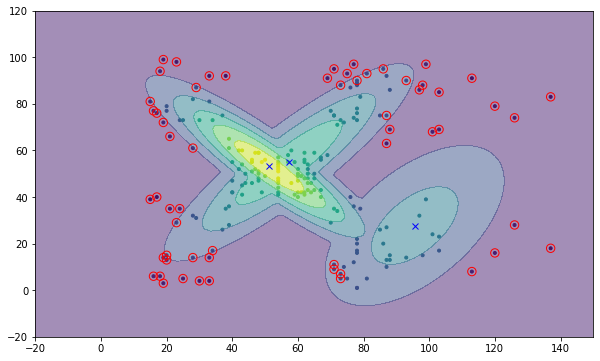

In [21]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

outlier_prob = .0002
outliers = np.nonzero(pj<outlier_prob)[0]


xlist = np.linspace(-20, 150, 100)
ylist = np.linspace(-20, 120, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)
for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.show()

### In-class exercise (25 points)

Examine the cluster centers and determine whether you can find any reasonable interpretation of them.
Discuss in your report (5 points), and compare to last week's results with k-means. (20 points)

#### Discussion report (5 points)

YOUR ANSWER HERE



Examining the three cluster centers above it can be interpreted as cluster of

high income, low expenditure (saver),
low income, high expenditure (spendthrift)
average income, average expenditure. (average person)
We can also see a lot of outliers in all of the clusters

#### Do k-mean and compare the result

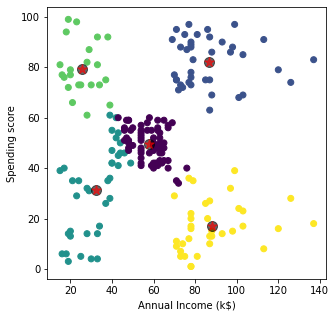

0.0


In [22]:
import random
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import pairwise_distances
from IPython.display import clear_output
import time

# 1. Initialize three random cluster centers
random.seed(400)
randomlist = random.sample(range(0, X.shape[0]),5) #using 5 clusters
centers = X[randomlist]
means =  np.zeros((centers.shape)) 

while True:
    
    # 2. Find the nearest cluster center for each point
    labels = pairwise_distances_argmin(X, centers)
        
    # 4. Find the mean of the points assigned to each cluster center
    for i in range(centers.shape[0]):
        means[i] = np.mean(X[np.where(labels == i)],axis = 0)
        
    plt.figure(figsize=(5, 5))
    plt.scatter(X[:, 0], X[:, 1], c=labels)
    plt.scatter(centers[:, 0], centers[:, 1], s=100,marker = 'o', c="black", alpha=0.6)
    plt.scatter(means[:, 0], means[:, 1], s=100,marker = '*', c="red", alpha=0.6)
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending score')
    plt.show()
    
    error = 0.0    
    for i in range(centers.shape[0]):
        error += ((means[i,:] - centers[i,:])**2).sum()
        
    print(error)
    if error < 1e-6:
        break
    else:
        centers = means 
    
    time.sleep(1)
    clear_output()

Means of K-means:
 [[44.15447154 49.82926829]
 [87.         18.63157895]
 [86.53846154 82.12820513]]


Means of GMMs:
 [[57.28749398 54.89123078]
 [95.58281619 27.73418382]
 [51.22191253 53.12655528]]


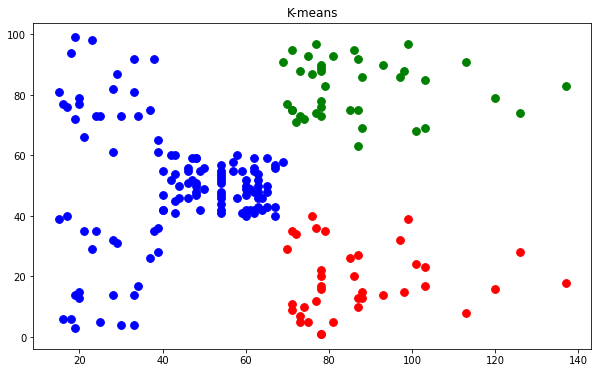

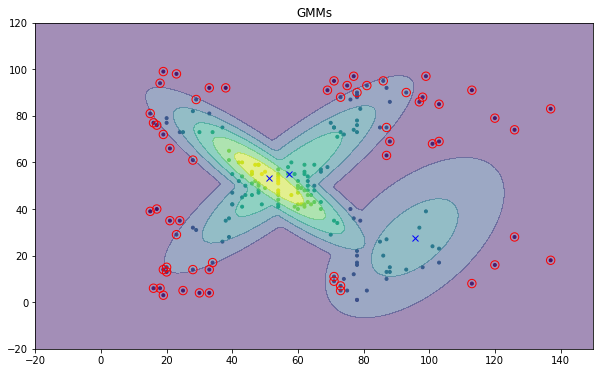

In [23]:
# YOUR CODE HERE
np.random.seed(32)

def init_kmeans(X, k):
    m = X.shape[0]
    n = X.shape[1]
    means = np.zeros((k,n))
    order = np.random.permutation(m)[:k]
    for i in range(k):
        means[i,:] = X[order[i],:]
    return means

# Run one iteration of k-means

def iterate_kmeans(X, means):
    m = X.shape[0]
    n = X.shape[1]
    k = means.shape[0]
    distortion = np.zeros(m)
    c = np.zeros(m)
    for i in range(m):
        min_j = 0
        min_dist = 0
        for j in range(k):
            dist_j = np.linalg.norm(X[i,:] - means[j,:])
            if dist_j < min_dist or j == 0:
                min_dist = dist_j
                min_j = j
        distortion[i] = min_dist
        c[i] = min_j
    for j in range(k):
        means[j,:] = np.zeros((1,n))
        nj = 0
        for i in range(m):
            if c[i] == j:
                nj = nj + 1
                means[j,:] = means[j,:] + X[i,:]
        if nj > 0:
            means[j,:] = means[j,:] / nj
    return means, c, np.sum(distortion)


epsilon = 0.001
k = 3
means = init_kmeans(X, k)
prev_distortion = 0
while True:
    means, c, distortion = iterate_kmeans(X, means)
    if prev_distortion > 0 and prev_distortion - distortion < epsilon:
        break
    prev_distortion = distortion

print("Means of K-means:\n", means)
print("\n")
print("Means of GMMs:\n", Mu.T)
# Set labels in dataset to cluster IDs according to k-means model.
df = data.copy()

df["label"] = c

# Plot the data

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.scatter(df["Annual Income (k$)"][df.label == 0], df["Spending Score (1-100)"][df.label == 0], c='blue', s=60)
ax.scatter(df["Annual Income (k$)"][df.label == 1], df["Spending Score (1-100)"][df.label == 1], c='red', s=60)
ax.scatter(df["Annual Income (k$)"][df.label == 2], df["Spending Score (1-100)"][df.label == 2], c='green', s=60)
plt.title("K-means")
plt.show()

fig = plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')
plt.title("GMMs")
plt.show()

#raise NotImplementedError()

### In-class exercise (10 points)

Do the same analysis with Mahalanobis distance as in the first example.

In [24]:
outlier = None
outlier = 0.01
# YOUR CODE HERE
m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        # get all row data from target column
        mu = Mu[:,kk]
        # get target sigma
        sig = Sigma[kk,:,:]
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(-1,1)
        # calculate distance from diff and sigma
        distance = np.sqrt(np.dot(np.dot(diff.T, sig_inv),diff))
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = np.unique(np.argmin(m_distance,axis=1)), len(np.unique(np.argmin(m_distance,axis=1)))

max_z_score = 2.  
# find minimum distance
# hint: use np.min
min_distance = np.min(m_distance, axis=1)
# find outlier from min_distance
outlier = np.where(min_distance > max_z_score)
# raise NotImplementedError()
# YOUR CODE HERE
#raise NotImplementedError()

outlier (array([  0,   3,   4,   8,   9,  11,  16,  17,  19,  22,  30,  32,  33,
        41, 123, 127, 145, 189, 193, 195, 198, 199]),)


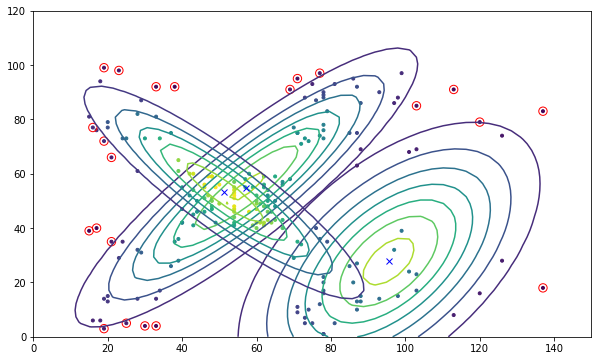

success!


In [25]:
# Test function: Do not remove
print('outlier', outlier)

plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(0, 150, 50)
    ylist = np.linspace(0, 120, 50)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX, YY, Z)

plt.show()
print('success!')
# End test function

### Example 3 Customer segmentation

This example is based on [Nguyen Hanh's tutorial on Medium.com](https://medium.com/@nguyenbaha/buiding-customer-segmentation-by-gmm-from-scratch-4ea6adc3da1c). In this example we use the Kaggle [OnlineRetail.csv](https://www.kaggle.com/vijayuv/onlineretail) dataset for customer segmentation. 

In [26]:
import pandas as pd
data = pd.read_csv('Online_Retail.csv')
data = data.iloc[0:5000,:]
print(data.head())
data = data.drop(['InvoiceNo','Description', 'CustomerID'], axis = 1)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice CustomerID         Country  TotalSum  
0   12/1/2010       2.55      17850  United Kingdom     15.30  
1   12/1/2010       3.39      17850  United Kingdom     20.34  
2   12/1/2010       2.75      17850  United Kingdom     22.00  
3   12/1/2010       3.39      17850  United Kingdom     20.34  
4   12/1/2010       3.39      17850  United Kingdom     20.34  


In [27]:
print(data.dtypes)

StockCode       object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
Country         object
TotalSum       float64
dtype: object


Let's view the categorical and numeric columns:

In [28]:
categorical_colmns = data.select_dtypes(include=['object']).columns
print(categorical_colmns)
numerical_colmns = data._get_numeric_data().columns
print(numerical_colmns)

Index(['StockCode', 'InvoiceDate', 'Country'], dtype='object')
Index(['Quantity', 'UnitPrice', 'TotalSum'], dtype='object')


In [29]:
def missing_percentage(data):
    """This function takes a DataFrame(df) as input and returns two columns, 
     total missing values and total missing values percentage"""
    total = data.isnull().sum().sort_values(ascending = False)
    percent = round(data.isnull().sum().sort_values(ascending = False)/len(data)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])


missing_percentage(data)



,Total,Percent
TotalSum,48,0.96
Country,12,0.24
UnitPrice,0,0.00
InvoiceDate,0,0.00
Quantity,0,0.00
StockCode,0,0.00


Next, let's fill the "na" values with "No information" and 0

In [30]:
data[categorical_colmns] = data[categorical_colmns].fillna("No information")
data[numerical_colmns] = data[numerical_colmns].fillna(0)

print(data.head())

  StockCode  Quantity InvoiceDate  UnitPrice         Country  TotalSum
0    85123A         6   12/1/2010       2.55  United Kingdom     15.30
1     71053         6   12/1/2010       3.39  United Kingdom     20.34
2    84406B         8   12/1/2010       2.75  United Kingdom     22.00
3    84029G         6   12/1/2010       3.39  United Kingdom     20.34
4    84029E         6   12/1/2010       3.39  United Kingdom     20.34


In [31]:
data_new = data.drop(['StockCode','InvoiceDate', 'Country'], axis = 1)
data_new

,Quantity,UnitPrice,TotalSum
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34
...,...,...,...
4995,120,0.42,50.40
4996,120,0.42,50.40
4997,120,0.42,50.40
4998,48,0.55,26.40


In [32]:
# def category_to_numeric(categorical_columns):
#     i = 0;
#     columnname = '';
#     while i < len(categorical_colmns):
#         col_idx = data.columns.get_loc(categorical_colmns[i])
#         distinct_values = data[categorical_colmns[i]].unique()
#         j = 0;    
#         for val in distinct_values:
#             idx = np.where(data[categorical_colmns[i]] == val);
#             data.iloc[idx[0],col_idx] = j            
#             j = j + 1;
#         i = i + 1;
        
        
# category_to_numeric(data[categorical_colmns])

# data = data.astype('float64')
# print(data.head())

Q1 = data_new.quantile(0.1) #removing the outliers completely beyond the 0.1 and 0.8 percentile for simplicity
Q3 = data_new.quantile(0.8)

#we only take data within the Quartiles
data_new = data_new[~((data < (Q1)) |(data_new > (Q3))).any(axis=1)]

In [38]:
Mu = np.mean(data_new[numerical_colmns])
Sigma = np.std(data_new[numerical_colmns])
print(Mu)
print(Sigma)

Quantity     5.216853
UnitPrice    2.180232
TotalSum     9.524225
dtype: float64
Quantity     3.990967
UnitPrice    0.964410
TotalSum     6.339384
dtype: float64


In [39]:
# Check for outliers

def cnt_outlier(data,sigma, mu, inc_cols=[]):
    num_cols = data.select_dtypes(include=[np.number]).columns
    num_cols = [e for e in num_cols if e in inc_cols]
    outlier = (data[numerical_colmns]-mu).abs() > sigma**2
    return outlier.sum()

cnt_outlier(data_new,Sigma,Mu, numerical_colmns).sort_values(ascending=False)

UnitPrice    1036
TotalSum        0
Quantity        0
dtype: int64

In [40]:
if len(data_new[data_new.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(data_new[data_new.duplicated()]))
    print(data_new[data_new.duplicated(keep=False)].sort_values(by=list(data_new.columns)).head())
    data.drop_duplicates(inplace=True)
else:
    print("No duplicated entries found")

No. of duplicated entries:  2380
     Quantity  UnitPrice  TotalSum
326         1       1.65      1.65
363         1       1.65      1.65
368         1       1.65      1.65
370         1       1.65      1.65
371         1       1.65      1.65


## In-class and take-home exercise

Use the same GMM code as in the previous two examples on this dataset. Try to interepret the
results you get and plot the inliers/outliers with a Mahalanobis distance
threshold. Plot likelihood as a function of $k$ and determine whether there is an "elbow"
in the plot. How many clusters should you use? Describe your experiments and results in your report.

In [41]:
X = data_new.values

mean = np.mean(X,axis=0)
std = np.std(X,axis=0)

X = (X-mean)/std

print(X)

[[ 0.19622989  0.38341414  0.91109399]
 [ 0.19622989  1.25441312  1.70612391]
 [ 0.69736161  0.59079484  1.967979  ]
 ...
 [-0.80603355 -1.3793219  -1.23422483]
 [-1.05659941  0.79817555 -1.03704479]
 [-1.05659941  0.79817555 -1.03704479]]


In [ ]:
# Your code here

In [42]:
X_new =X[:, [1,2]] #qty and total sum
X_new.shape

(2504, 2)

In [43]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    np.random.seed(40)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.inv(covariance) * X, axis=1))
    return p

def Mahalanobis_distance(X, mean, covariance):
    X = X - mean.T
    ans = np.sqrt(np.sum(X @ np.linalg.inv(covariance) * X, axis=1))
#     print(ans)
    return ans
    

# Run one iteration of EM
def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j,:,:])
        pj_arr[0:m,j] = pj
        W[:,j] = Phi[j] * pj

    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(n,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False
        

    labels = np.argmax(pj_arr, axis = 1)
    pj = pj_arr[np.arange(0,m,1),labels]
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label


In [44]:
k = 3
Phi, Mu, Sigma = init_gmm(X_new, k)
threshold = threshold = np.matrix(.1)
converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X_new, threshold, Phi, Mu, Sigma)

In [45]:
print(Mu.shape)
m_distance = np.zeros((X_new.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X_new):
        # get all row data from target column
        mu = Mu[:,kk]
        # get target sigma
        sig = Sigma[kk,:,:]
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(-1,1)
        # calculate distance from diff and sigma
        distance = np.sqrt(np.dot(np.dot(diff.T, sig_inv),diff))
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = np.unique(np.argmin(m_distance,axis=1)), len(np.unique(np.argmin(m_distance,axis=1)))

max_z_score = 2
# find minimum distance
# hint: use np.min
min_distance = np.min(m_distance, axis=1)
# find outlier from min_distance
outlier = np.where(min_distance > max_z_score)

(2, 3)


(2504, 2)


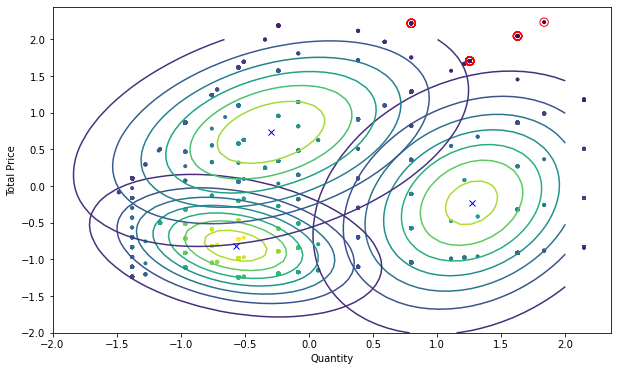

In [46]:
print(X_new.shape)
# Test function: Do not remove
# print('outlier', outlier)

plt.figure(figsize=(10,6))
plt.scatter(X_new[:,0],X_new[:,1],marker=".",c=pj,cmap='viridis');

plt.scatter(X_new[outlier,0],X_new[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

for c in np.arange(0,k):    
    X_class = X_new[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(-2, 2, 50)
    ylist = np.linspace(-2, 2, 50)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
#             print("pt", pt)
#             print("mu", Mu[:2,c])
#             print(Sigma)
            Z[i,j] = Gaussian(pt, Mu[:2,c], Sigma[c])
            j = j + 1
        i = i + 1    
        
    cp = plt.contour(XX, YY, Z)
plt.xlabel('Quantity')
plt.ylabel('Total Price')
plt.show()

We can see using three clusters that we have groups with
high unit cost and average quantity
average quantity and low unit cost
Clusters 2 and 3 have a lot of overlap in terms of high quality and low unit price.

In [51]:
def cost(X_label, Mu):
    loss = np.inf
    for j in range(Mu.shape[1]) : 
        Muj = Mu.T[j]
        Xj = X_label[X_label[:, -1] == j][:, :-1]
        loss = min(loss, np.min(np.linalg.norm(Xj-Muj)))
    return loss

likelihood = []
for k in range(1,4):
    threshold = np.matrix(.01)

    Phi, Mu, Sigma = init_gmm(X_new, k)

    converged = False
    while not converged:
        converged, pj, X_label = iterate_em_gmm(X_new, threshold, Phi, Mu, Sigma)
    loss = cost(X_label, Mu)
    likelihood.append(loss)

[70.76722405 36.56522309 21.84915052]


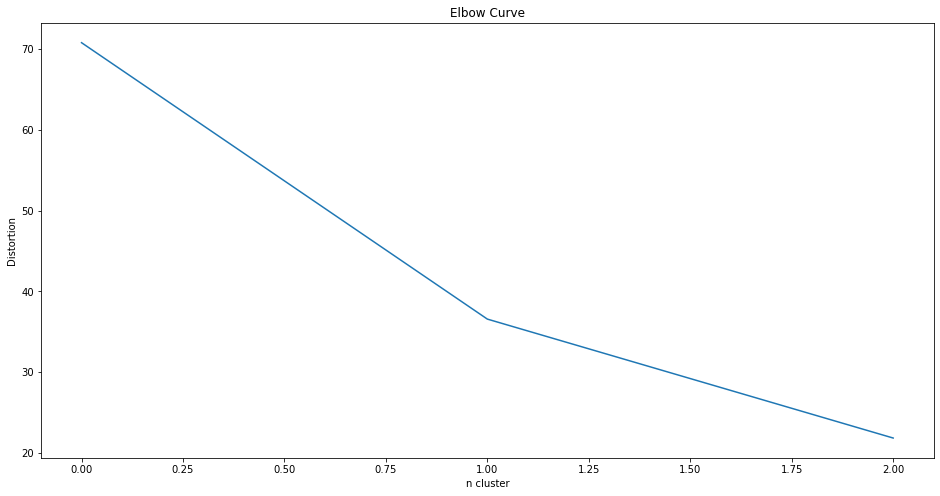

In [49]:
likelihood = np.array(likelihood)
print(likelihood)
plt.figure(figsize=(16,8))
plt.plot(likelihood)
plt.xlabel('n cluster')
plt.ylabel('Distortion')
plt.title('Elbow Curve')
plt.show()

The cluster seems optimum at 2 or 3 so either will work. It makes sense because the clusters 2 and 3 were almost the same in the previous plot.

In [50]:
len(X_label[outlier,1])

1